# Detection — YoloV8
**Author:** Sayed Pedram Haeri Boroujeni  
**Position:** PhD Student, Clemson University  
**Affiliation:** Department of Computer Science  
**Email:** shaerib@g.clemson.edu  
**Date Created:** October 10, 2025  

##### 1. Importing Required Libraries

In [1]:
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
import xml.etree.ElementTree as ET
import shutil
import yaml
import glob

import argparse, os, random, time, math
import torch, torch.nn as nn, torch.nn.functional as F
import torch.backends.cudnn as cudnn
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import confusion_matrix
from torchvision.transforms import functional as TF 

##### 2. Checking GPU Availability

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

CUDA Available: True
CUDA Version: 12.6
Number of GPUs: 1
Device Name: NVIDIA RTX A5000


##### 3. Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(7)

##### 4. Configuration

In [4]:
# Base dataset directory
data_dir = r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet"
splits = ["train", "val", "test"]
classes = ["fire", "no_fire"]

model_name = "yolov8n.pt"   # choose: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
epochs = 10
batch_size = 16
img_size = 640
learning_rate = 1e-3

# Verify the model is loaded
model = YOLO(model_name)
model.info()

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

##### 5. Dataset Preparation

In [5]:
def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center = (box[0] + box[1]) / 2.0
    y_center = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def xml_to_txt(xml_path, txt_path, class_list):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)
    with open(txt_path, "w") as out_file:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in class_list:
                continue
            cls_id = class_list.index(cls)
            xmlbox = obj.find("bndbox")
            b = (
                float(xmlbox.find("xmin").text),
                float(xmlbox.find("xmax").text),
                float(xmlbox.find("ymin").text),
                float(xmlbox.find("ymax").text),
            )
            bb = convert_bbox((w, h), b)
            out_file.write(f"{cls_id} {' '.join([f'{a:.6f}' for a in bb])}\n")

for split in splits:
    img_dir = os.path.join(data_dir, split, "images")
    lbl_dir = os.path.join(data_dir, split, "labels")
    print(f"\n Checking {split} set...")

    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    converted = 0
    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        xml_path = os.path.join(lbl_dir, base + ".xml")
        txt_path = os.path.join(lbl_dir, base + ".txt")
        if os.path.exists(xml_path) and not os.path.exists(txt_path):
            xml_to_txt(xml_path, txt_path, classes)
            converted += 1
    print(f"✅ {split.upper()}: {len(image_files)} images, converted {converted} XMLs to TXT")


 Checking train set...
✅ TRAIN: 350 images, converted 0 XMLs to TXT

 Checking val set...
✅ VAL: 100 images, converted 0 XMLs to TXT

 Checking test set...
✅ TEST: 50 images, converted 0 XMLs to TXT


##### 6. Data Loading

In [10]:
wildfire_config = {
    "train": os.path.join(data_dir, "train", "images").replace("\\", "/"),
    "val": os.path.join(data_dir, "val", "images").replace("\\", "/"),
    "test": os.path.join(data_dir, "test", "images").replace("\\", "/"),
    "nc": 2,
    "names": ["fire", "no_fire"],
}

yaml_path = os.path.join(data_dir, "wildfire.yaml")
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(wildfire_config, f, sort_keys=False)
print(f"\n wildfire.yaml created at:\n{yaml_path}")


 wildfire.yaml created at:
C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet\wildfire.yaml


In [7]:
# Sanity Check for Dataset
for split in ["train", "val", "test"]:
    img_dir = os.path.join(data_dir, split, "images")
    lbl_dir = os.path.join(data_dir, split, "labels")

    img_count = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    lbl_count = len([f for f in os.listdir(lbl_dir) if f.lower().endswith('.txt')])

    print(f"📂 {split.upper():<5} → Images: {img_count}, Labels: {lbl_count}")
    if img_count == 0 or lbl_count == 0:
        print(f"  Missing data in {split}/images or {split}/labels!\n")

# Show sample label for verification
sample_label = os.path.join(data_dir, "train", "labels", os.listdir(os.path.join(data_dir, "train", "labels"))[0])
print("\n Sample label content:")
with open(sample_label, "r") as f:
    print(f.read())

📂 TRAIN → Images: 350, Labels: 350
📂 VAL   → Images: 100, Labels: 100
📂 TEST  → Images: 50, Labels: 50

 Sample label content:
0 0.558824 0.772973 0.338235 0.248649



In [8]:
# Clear Old YOLO Caches
print(" Cleaning YOLO dataset cache files...\n")
deleted = 0

for cache_file in glob.glob(os.path.join(data_dir, "**", "*.cache"), recursive=True):
    try:
        os.remove(cache_file)
        print(f" Deleted cache: {cache_file}")
        deleted += 1
    except Exception as e:
        print(f" Could not delete {cache_file}: {e}")

if deleted == 0:
    print("No cache files found — fresh start!")
else:
    print(f"{deleted} cache files removed successfully.\n")

 Cleaning YOLO dataset cache files...

 Deleted cache: C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet\train\labels.cache
 Deleted cache: C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet\val\labels.cache
2 cache files removed successfully.



##### 7. YoloV8 Training Loop

In [11]:
print("Starting YOLOv8 training...\n")

model = YOLO(model_name)
output_dir = os.path.join(data_dir, "runs")
os.makedirs(output_dir, exist_ok=True)

results = model.train(
    data=yaml_path,
    epochs=epochs,
    imgsz=img_size,
    batch=batch_size,
    lr0=learning_rate,
    project=output_dir,
    name="YOLOv8_Wildfire",
    device=device,
)

print("\nTraining complete!")
print(f"Results saved to: {results.save_dir}")

Starting YOLOv8 training...

engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FireNet\wildfire.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8_Wildfire2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

##### 9. Plot Training Curves

 Loading results from: C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\runs\YOLOv8_Wildfire



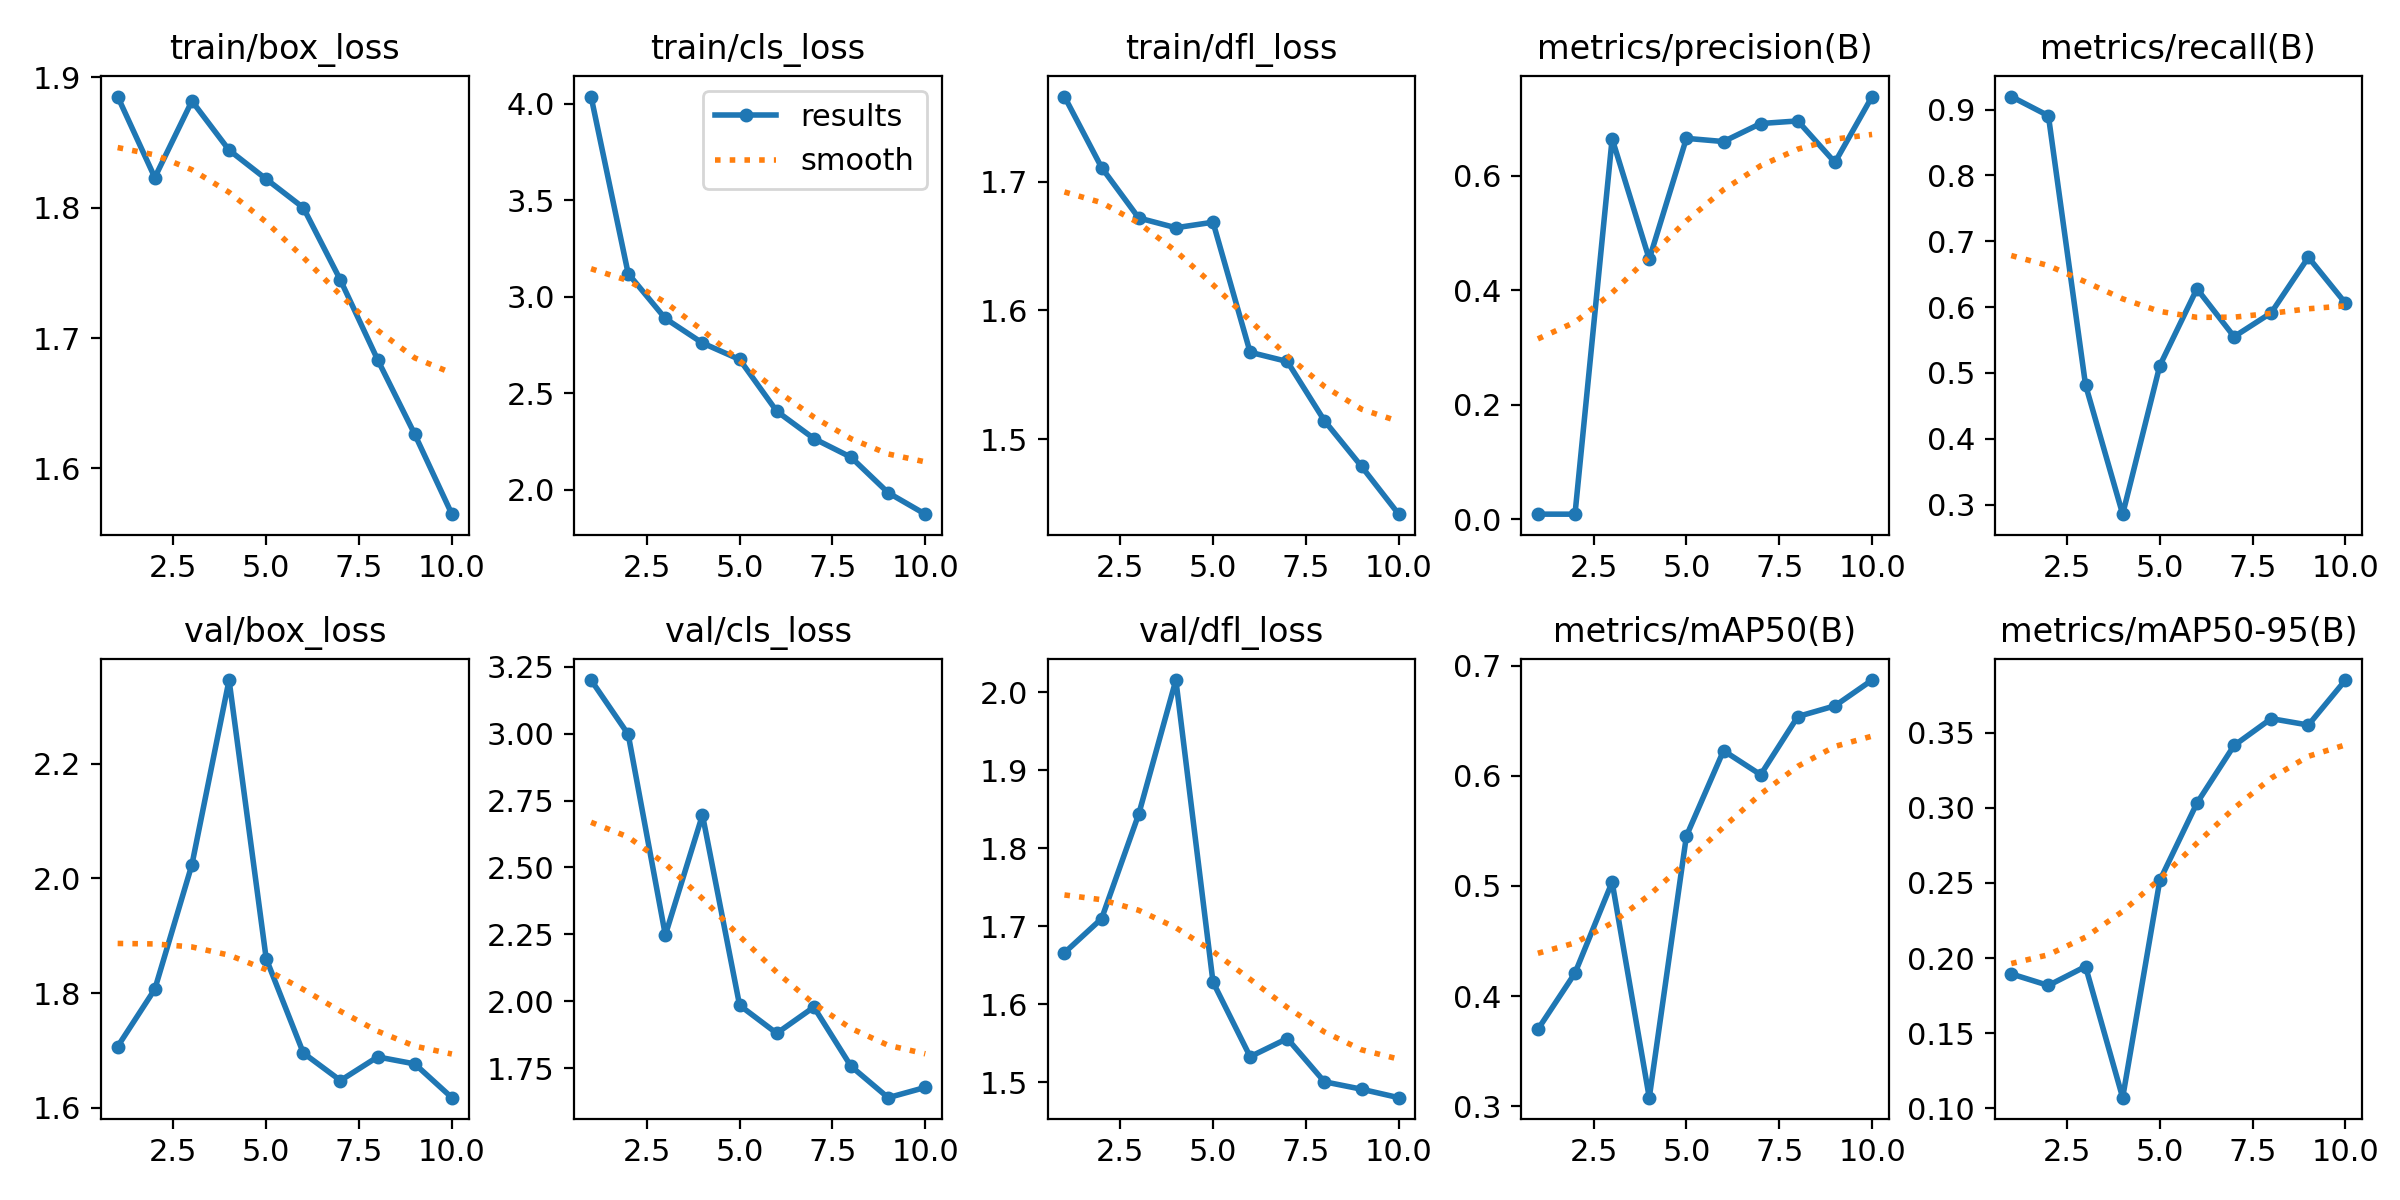


 Loading trained model from: C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\runs\YOLOv8_Wildfire\weights\best.pt

 Running validation to visualize predictions...
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 59.519.8 MB/s, size: 9.0 KB)
val: Scanning C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 50.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.7it/s 4.1s0.2ss
                   all        100        137      0.751      0.599      0.681      0.385
                  fire        100        137      0.751      0.599      0.681      0.385
Speed: 0.6ms preprocess, 8.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\shaerib\runs\detect\val8

 Showing random validation pre

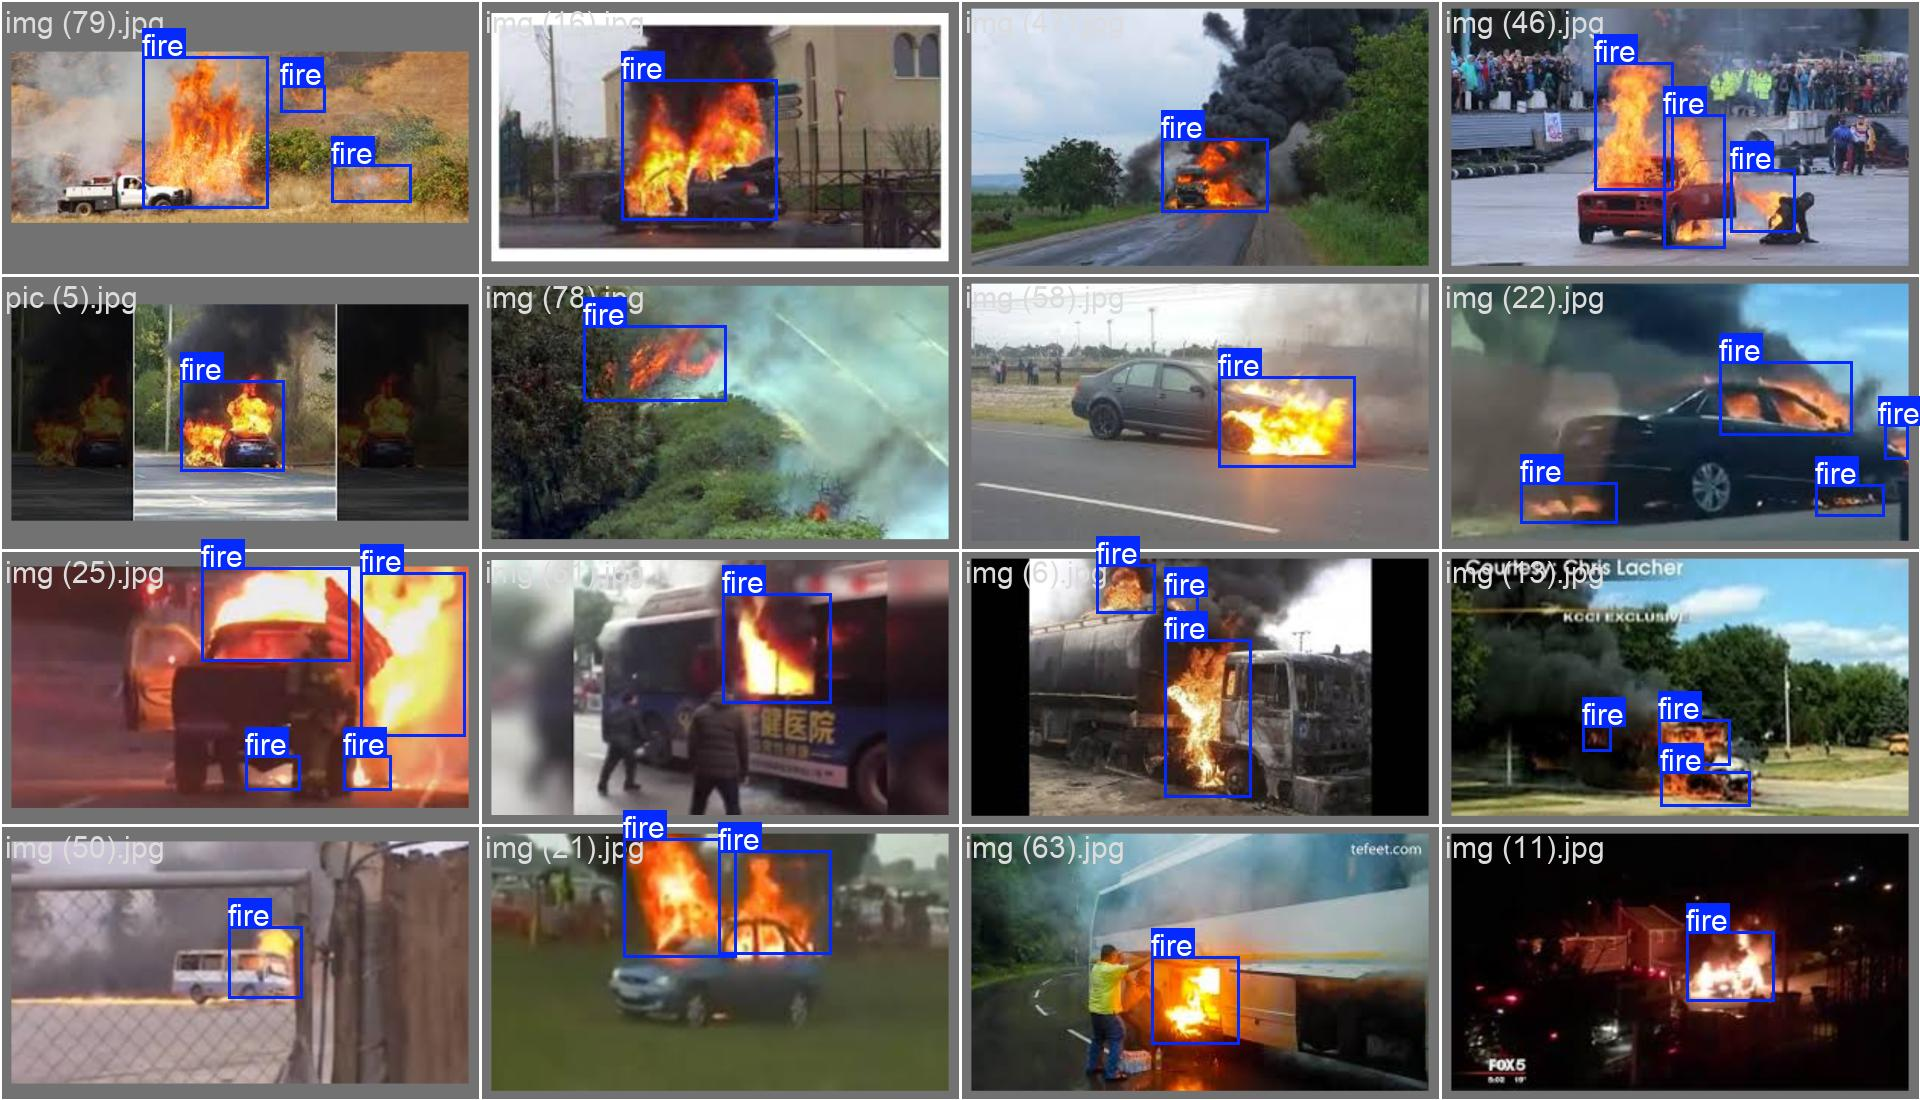

In [13]:
# Visualize Training 
import random
from IPython.display import Image, display
from pathlib import Path


run_dir = Path(os.path.join(data_dir, "runs", "YOLOv8_Wildfire"))
print(f" Loading results from: {run_dir}\n")

# --- Show YOLO training result images ---
image_files = [
    "results.png",
    #"confusion_matrix.png",
    #"labels.jpg",
    "F1_curve.png",
    "PR_curve.png"
]

for file in image_files:
    path = run_dir / file
    if path.exists():
        display(Image(filename=str(path)))

# --- Load best model and run validation once ---
weights_path = run_dir / "weights" / "best.pt"
if not weights_path.exists():
    print("best.pt not found.")
else:
    print(f"\n Loading trained model from: {weights_path}")
    model = YOLO(str(weights_path))  # should now work fine

    print("\n Running validation to visualize predictions...")
    val_results = model.val(save=True, imgsz=img_size, device=device)

    # Display a random validation image with predictions
    val_folder = Path(val_results.save_dir)
    pred_images = list(val_folder.glob("*.jpg"))
    if pred_images:
        rand_pred = random.choice(pred_images)
        print(f"\n Showing random validation prediction:\n{rand_pred}")
        display(Image(filename=str(rand_pred)))
    else:
        print(" No prediction images found after validation.")

##### 10. Evaluation on Test Set

 Loaded trained model from: C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\runs\YOLOv8_Wildfire\weights\best.pt

 Evaluating model on test set...

Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1.20.9 MB/s, size: 7.4 KB)
val: Scanning C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\test\labels... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 336.4it/s 0.1s.3s
val: New cache created: C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.1it/s 3.5s0.4ss
                   all         50         79       0.79      0.772      0.829      0.343
                  fire         50         79       0.79      0.772      0.829      0.343
Speed: 1.1ms preprocess, 8.9ms inference, 0.0ms loss, 3.6ms postprocess pe

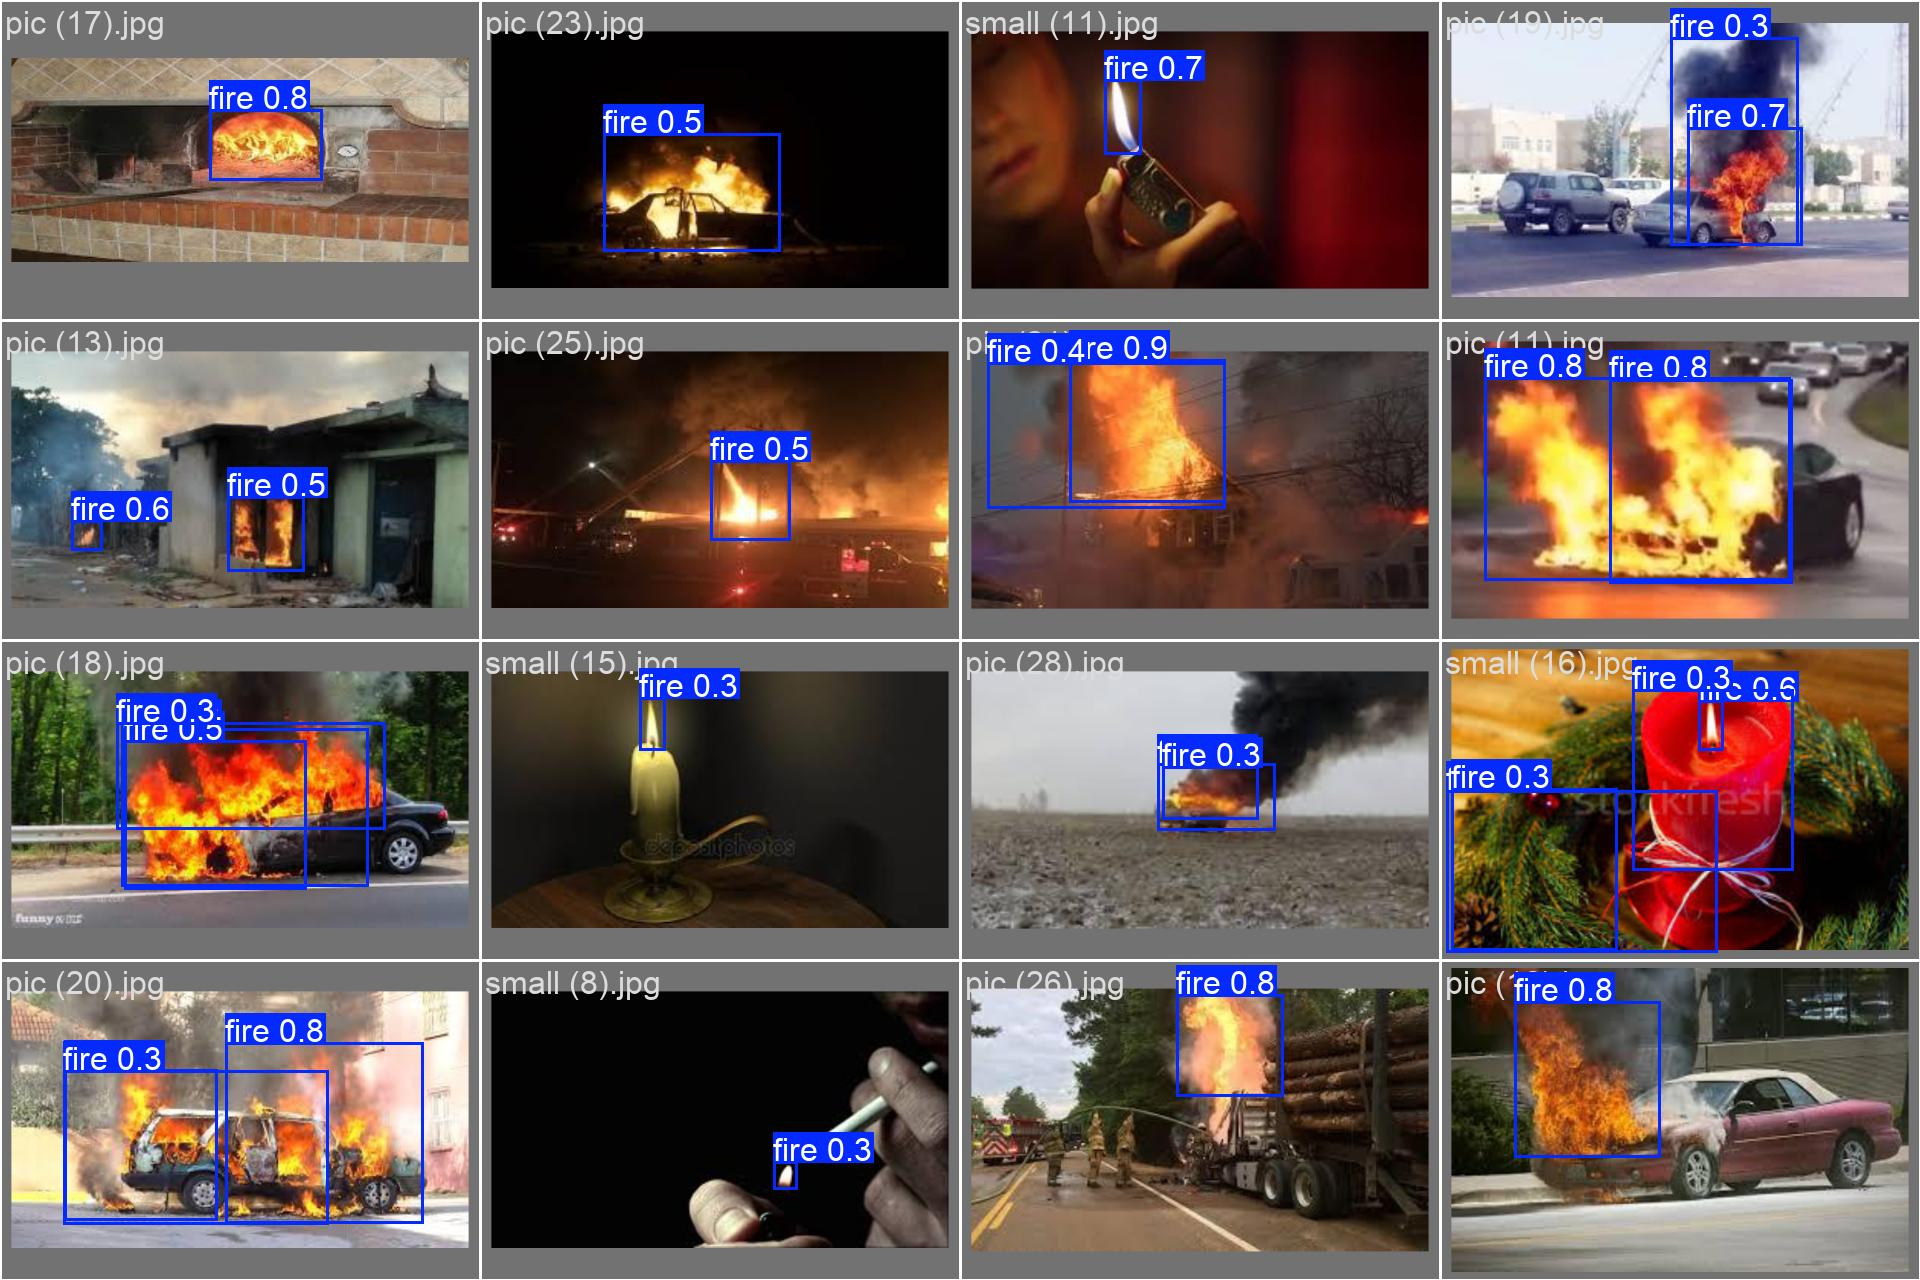

 val_batch1_labels.jpg


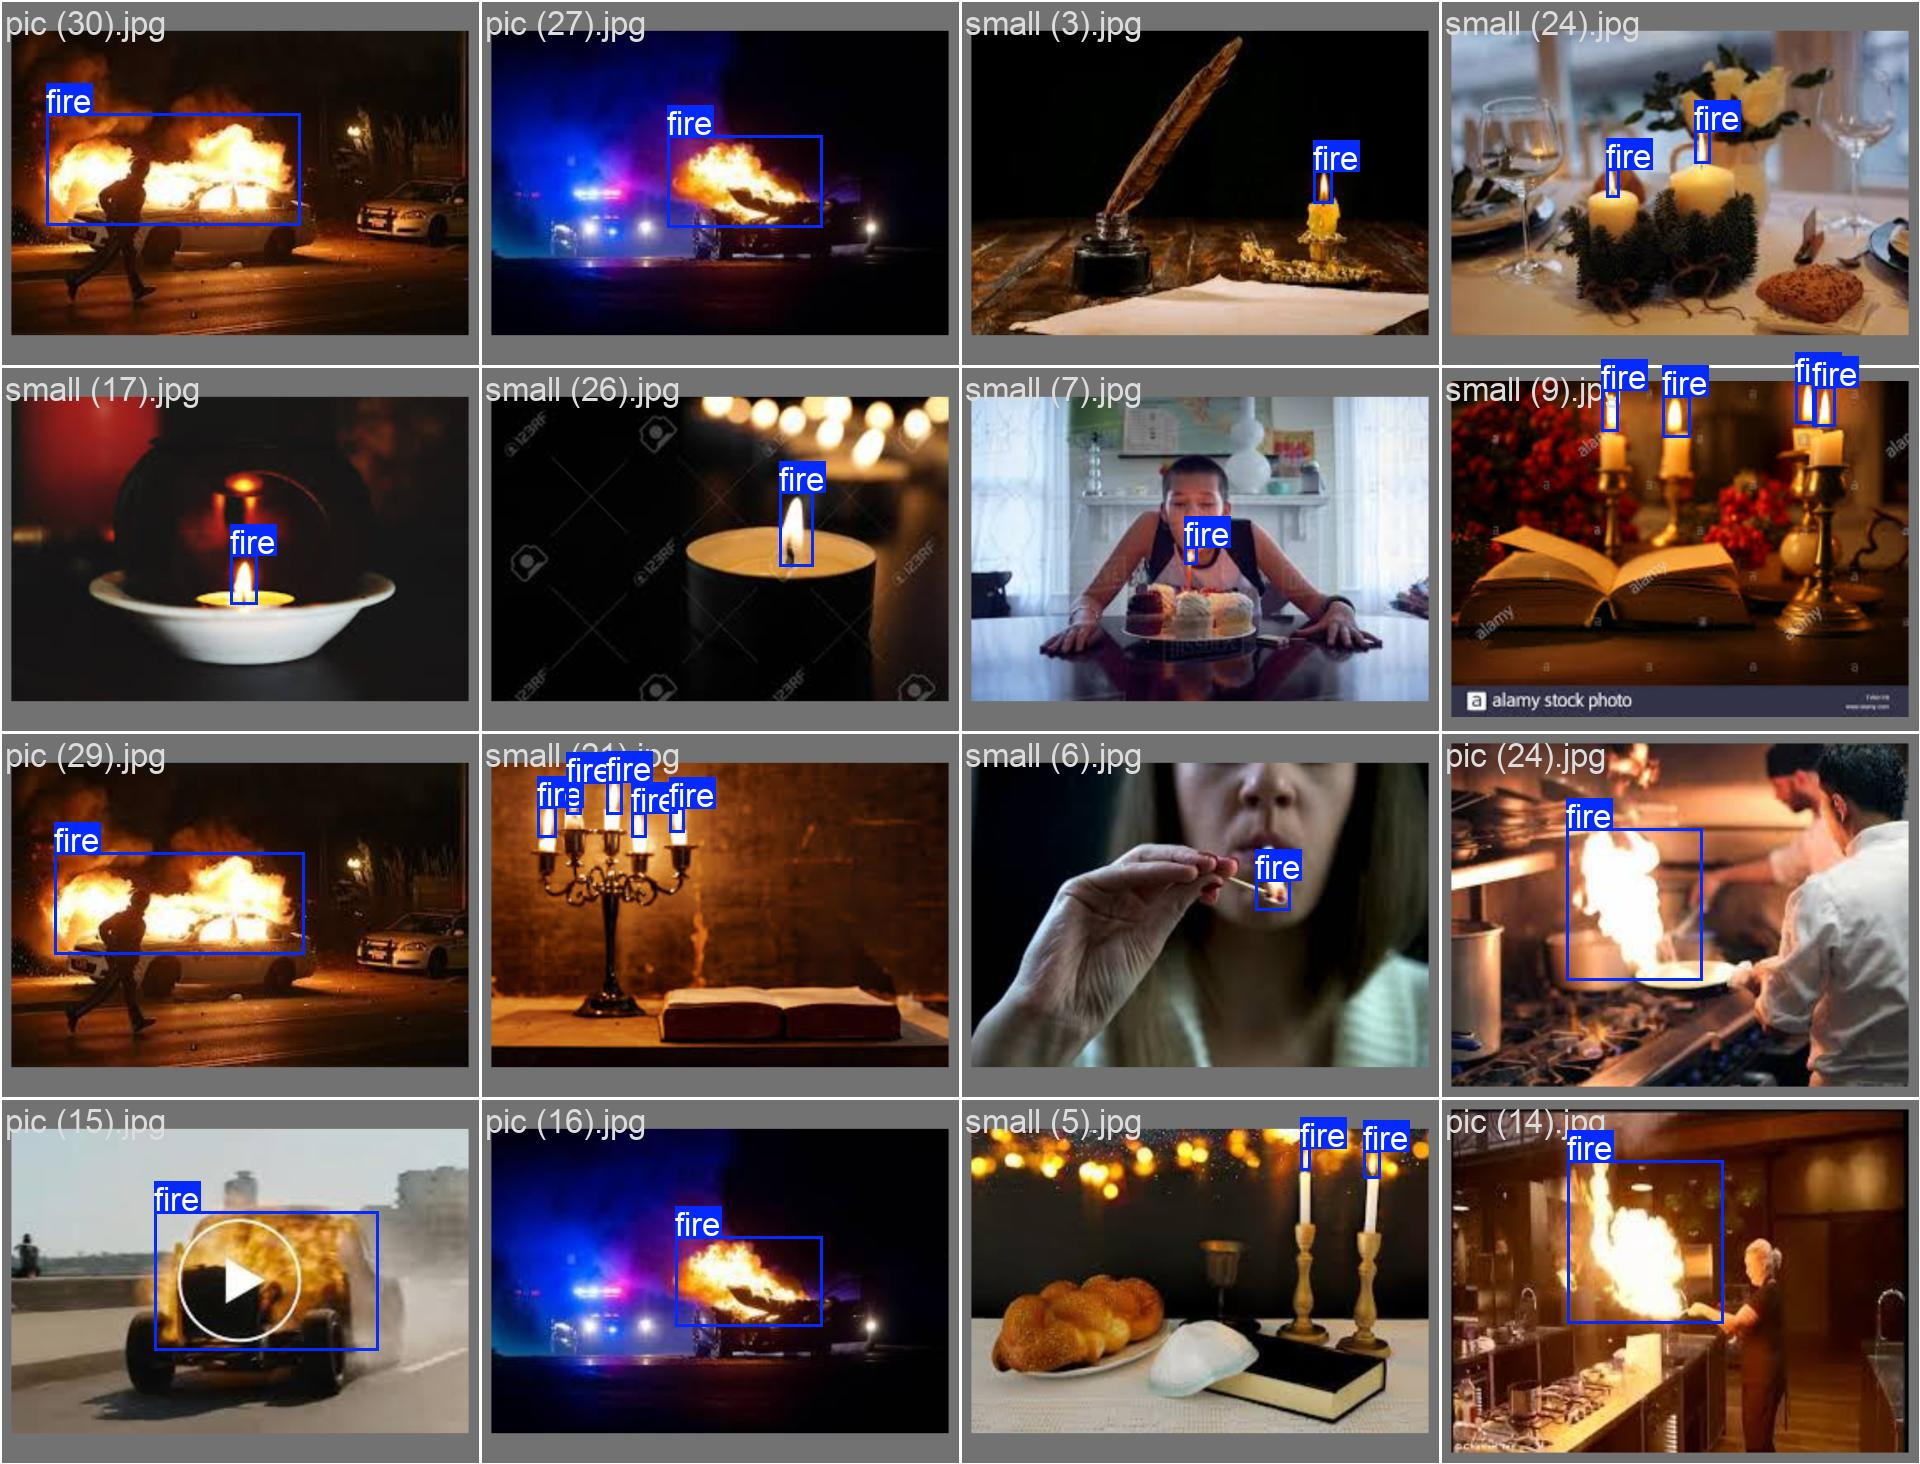

 val_batch0_labels.jpg


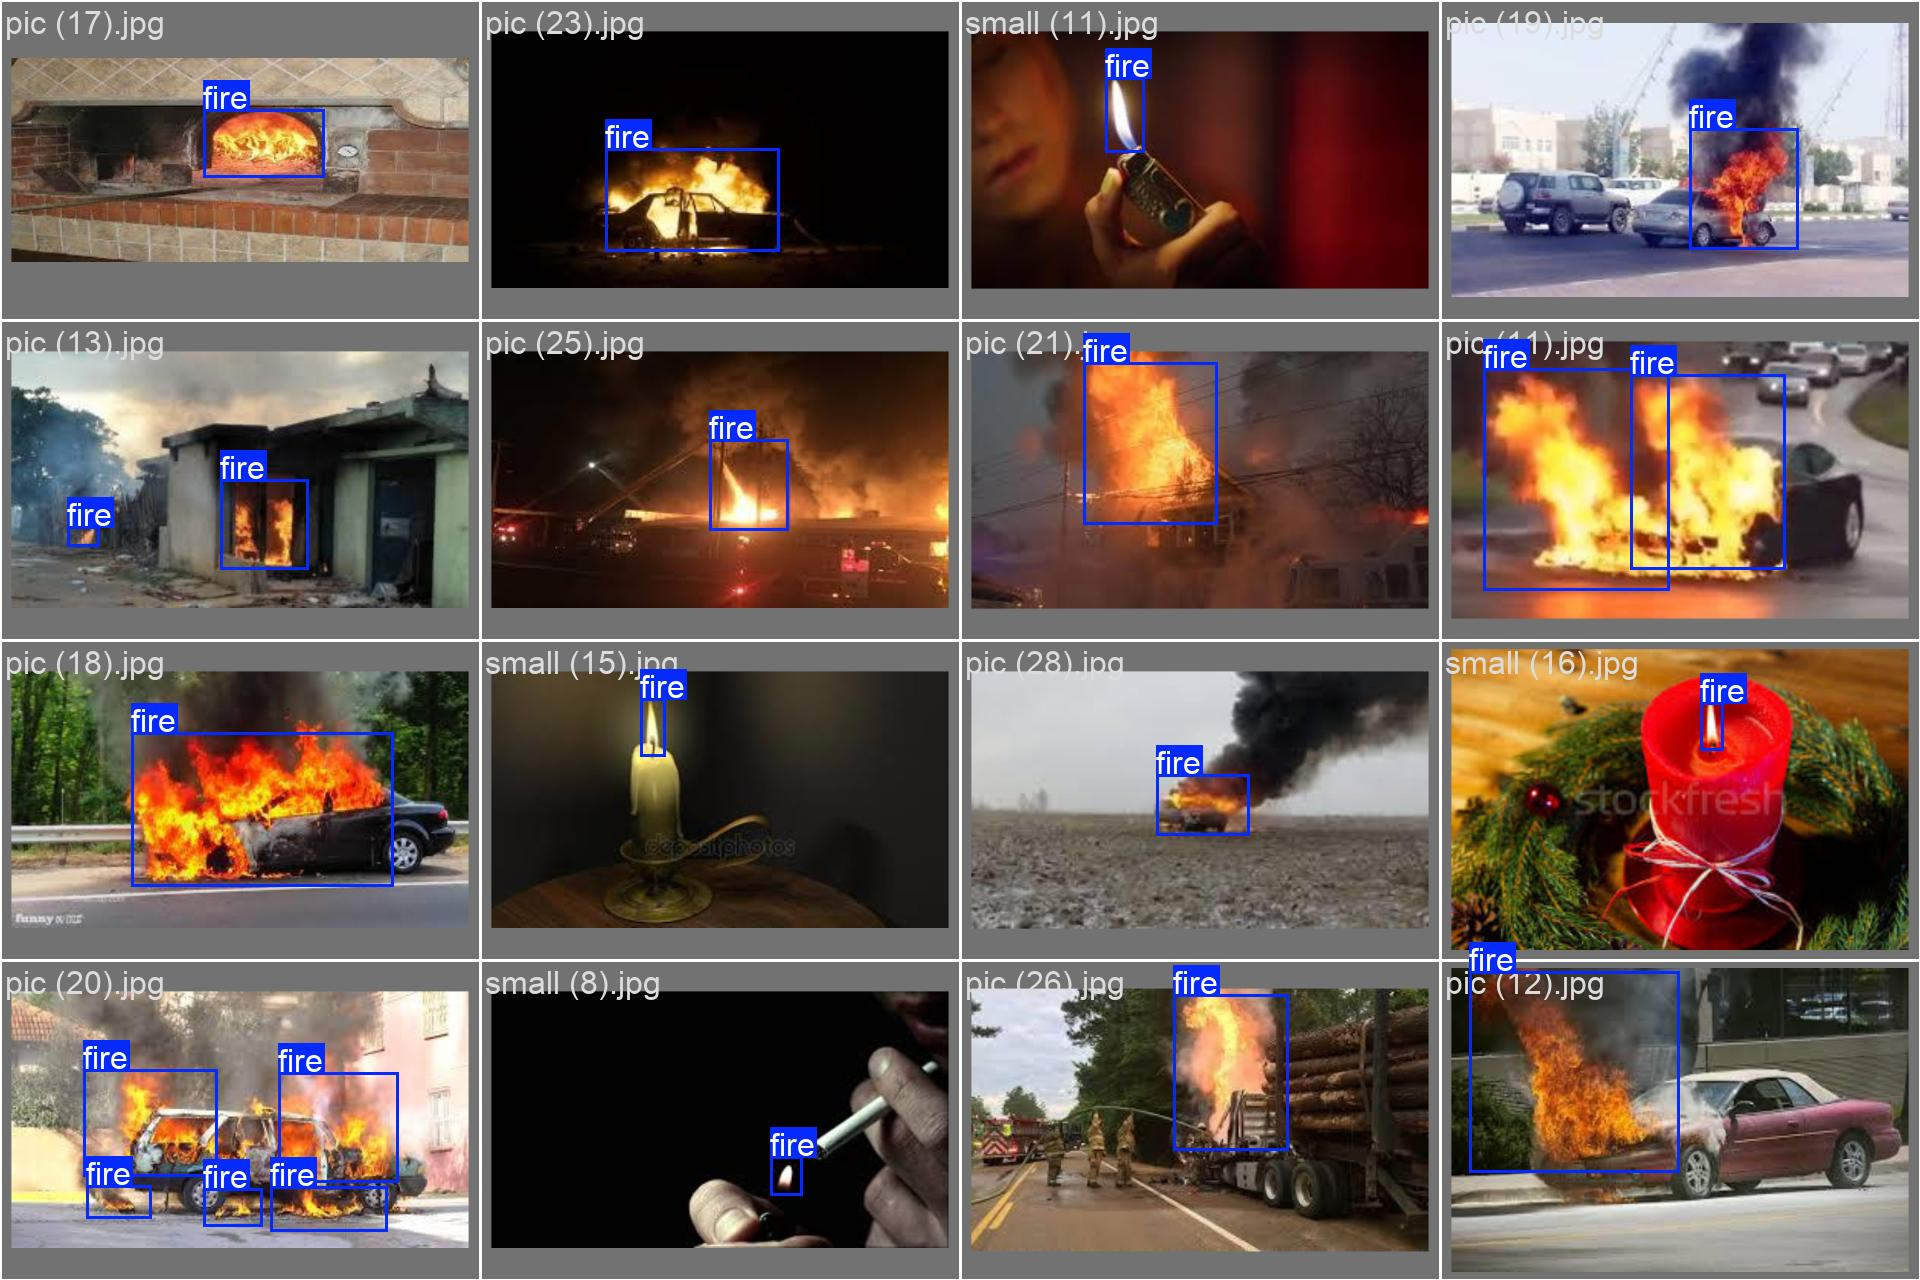

In [14]:
# Load best model
weights_path = Path(os.path.join(data_dir, "runs", "YOLOv8_Wildfire", "weights", "best.pt"))
if not weights_path.exists():
    raise FileNotFoundError(f" Trained model not found at {weights_path}")

print(f" Loaded trained model from: {weights_path}")

model = YOLO(str(weights_path))

# Run evaluation on test set
print("\n Evaluating model on test set...\n")

test_results = model.val(
    data=yaml_path,          # same wildfire.yaml
    split="test",            # explicitly test split
    imgsz=img_size,
    device=device,
    save=True,               # save predicted images
    verbose=True
)

# Print key metrics
print("\n Evaluation Metrics:")
print(f"mAP@0.5: {test_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {test_results.box.map:.4f}")
print(f"Precision: {test_results.box.mp:.4f}")
print(f"Recall: {test_results.box.mr:.4f}")


test_folder = Path(test_results.save_dir)
pred_images = list(test_folder.glob("*.jpg"))

if len(pred_images) > 0:
    rand_preds = random.sample(pred_images, min(3, len(pred_images)))
    print(f"\n Showing {len(rand_preds)} random test predictions:\n")
    for img_path in rand_preds:
        print(f" {img_path.name}")
        display(Image(filename=str(img_path)))
else:
    print("No test prediction images found.")

##### 12. Cross-Dataset Evaluation

In [16]:
# Base path where all wildfire datasets are stored
base_path = r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset"

# Toggle datasets you want to test (True = evaluate, False = skip) ---
test_datasets = {
    "D-Cluster":  False,
    "FireDetn":   False,
    "D-Fire":     False,
    "FireNet":    True,
    "Flame3":     False,
}

# Path to your trained YOLOv8 model 
weights_path = os.path.join(
    base_path, "FireNet", "runs", "YOLOv8_Wildfire", "weights", "best.pt"
)
if not os.path.exists(weights_path):
    raise FileNotFoundError(f" best.pt not found at {weights_path}")

print(f" Loaded trained YOLOv8 model from:\n   {weights_path}\n")
model = YOLO(weights_path)

# Function to evaluate YOLOv8 model on a dataset 
def evaluate_yolo_on_dataset(model, dataset_dir, device="cuda"):
    """
    Evaluate YOLOv8 model on a dataset directory structured as:
    dataset/
        ├── train/
        ├── val/
        └── test/
            ├── images/
            └── labels/
    A wildfire.yaml file must exist in the dataset root.
    """
    yaml_path = os.path.join(dataset_dir, "wildfire.yaml")
    if not os.path.exists(yaml_path):
        print(f" Skipping {dataset_dir} — wildfire.yaml not found.")
        return None

    print(f" Evaluating {os.path.basename(dataset_dir)} ...")
    results = model.val(
        data=yaml_path,
        split="test",
        imgsz=640,
        device=device,
        save=False,
        verbose=False
    )

    metrics = {
        "mAP@0.5": round(results.box.map50, 4),
        "mAP@0.5:0.95": round(results.box.map, 4),
        "Precision": round(results.box.mp, 4),
        "Recall": round(results.box.mr, 4),
    }
    return metrics

# Evaluate all active datasets 
summary = {}
print("\n Starting Cross-Dataset Evaluation...\n")

for name, active in test_datasets.items():
    if not active:
        continue

    dataset_dir = os.path.join(base_path, name)
    if not os.path.exists(dataset_dir):
        print(f" Dataset not found: {dataset_dir}")
        continue

    metrics = evaluate_yolo_on_dataset(model, dataset_dir, device="cuda")
    if metrics is not None:
        summary[name] = metrics
        print(f" Results for {name}: {metrics}\n")

# Summarize all results 
if summary:
    print("\n📋 Cross-Dataset Evaluation Summary:")
    print(f"{'Dataset':<20} {'mAP@0.5':<10} {'mAP@0.5:0.95':<14} {'Precision':<10} {'Recall':<10}")
    print("-" * 65)
    for name, m in summary.items():
        print(f"{name:<20} {m['mAP@0.5']:<10} {m['mAP@0.5:0.95']:<14} {m['Precision']:<10} {m['Recall']:<10}")

    avg_map50 = np.mean([m["mAP@0.5"] for m in summary.values()])
    avg_map95 = np.mean([m["mAP@0.5:0.95"] for m in summary.values()])
    print("\n🔹 Average mAP@0.5:      ", round(avg_map50, 4))
    print("🔹 Average mAP@0.5:0.95: ", round(avg_map95, 4))
else:
    print("No datasets evaluated — enable at least one in test_datasets.")


 Loaded trained YOLOv8 model from:
   C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset\FireNet\runs\YOLOv8_Wildfire\weights\best.pt


 Starting Cross-Dataset Evaluation...

 Evaluating FireNet ...
Ultralytics 8.3.208  Python-3.12.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA RTX A5000, 24564MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 64.836.8 MB/s, size: 8.2 KB)
val: Scanning C:\Users\shaerib\OneDrive - Clemson University\Desktop\Dataset\FireNet\test\labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 50.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.2it/s 3.3s0.4ss
                   all         50         79       0.79      0.772      0.829      0.343
Speed: 1.0ms preprocess, 5.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\shaerib\runs\detect\val11
 Results